In [27]:
from __future__ import division
import tqdm
import glob
import numpy as np
import sys
sys.path.append('/workspace/projects/TES/scripts/TESPulseFitCode')
# sys.path.append('/workspace/projects/TES/scripts')
import pulse_fit_v05 as pf
import single_photon_model_no_shift as noshift
import heralded_pulses_analysis as hpa
import pulse_averaging as pa
import thres_poiss
import pulse_discrimination as pd
import matplotlib.pyplot as plt
from lmfit import Model, Parameters
import pymc
import matplotlib
import seaborn
from scipy.signal import savgol_filter
%matplotlib inline

# Single Photon Model

In [28]:
# Imports single diode excitation traces
directory_name = '/workspace/projects/TES/data/20170405_TES5_SQ1_fit_accuracy_80mK_iBias_104uA_7.2GHZ_100kOhm/single/'
results_directory = './'
filelist = np.array(glob.glob(directory_name + '*.trc'))
print(filelist[:2])

[ '/workspace/projects/TES/data/20170405_TES5_SQ1_fit_accuracy_80mK_iBias_104uA_7.2GHZ_100kOhm/single/C2_diode_single_20MHz_bwl_00000.trc'
 '/workspace/projects/TES/data/20170405_TES5_SQ1_fit_accuracy_80mK_iBias_104uA_7.2GHZ_100kOhm/single/C2_diode_single_20MHz_bwl_00001.trc']


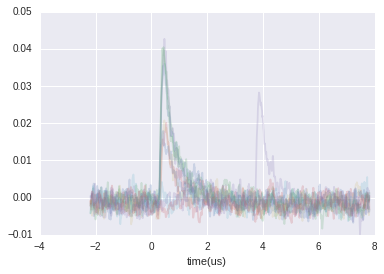

In [49]:
# Performs an initial plot
hpa.pplot(filelist[:100])

In [50]:
# Set left and right time limits of each trace to process
t_initial = -2e-6
t_final = None
height_th = 0.03 #to be updated with pt of minimal overlap between n=0 and n=1 distributions

In [30]:
# Extract trace properties, generate height histogram
data = np.array([hpa.param_extr(f,t_initial,t_final,height_th)
                 for f
                 in tqdm.tqdm(filelist[:10000])])

100%|██████████| 10000/10000 [00:22<00:00, 445.37it/s]


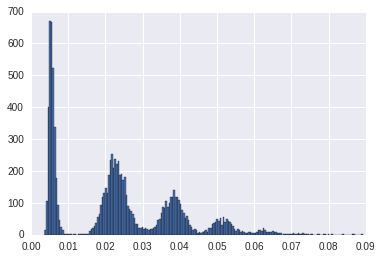

In [51]:
heights = data['height']
pnr_height = np.histogram(heights, 200)
plt.hist(heights,200);

In [52]:
# Noise Amplitude Standard Deviation
from scipy.stats import norm
(mu0,sigma0) = norm.fit(heights[(heights<0.01)])
print mu0, sigma0, sigma0/mu0

0.00563443861067 0.00082336365542 0.146130557508


In [97]:
# Single Photon Amplitude Standard Deviation
(mu,sigma) = norm.fit(heights[(heights>0.01)&(heights<0.03)])
print mu, sigma, sigma/mu

0.0226794441056 0.00286723632556 0.126424453448


In [54]:
# Detect valleys separating peaks
th = thres_poiss.thresholds_N(pnr_height, min_peak_sep=0.01, weighted=True)
print th

[(0.011951633036193437, 8.3784319488940006e-05, 2.2204460492503131e-16), (0.03046250031239402, 0.0037138535480532192, 0.0036548119323861483), (0.044919100788608411, 0.0090936648155094946, 0.0092101719547241778)]


In [109]:
# Update height threshold, ,reprocess trace parameters
height_th = th[0][0]
print height_th

0.0119516330362


In [56]:
data = np.array([hpa.param_extr(f,t_initial,t_final,h_th=height_th)
                 for f
                 in tqdm.tqdm(filelist[:10000])])

100%|██████████| 10000/10000 [00:37<00:00, 269.93it/s]


In [57]:
# Generate Height and Area histograms
heights = data['height']
areas = data['area_win']

# use the area to count the number of photons
pnr_height = np.histogram(heights, 200)
pnr = np.histogram(areas, 200)

# remove the first bin that is not gaussian, and will affect the threshold detection algorithm

pnr = [pnr[0][1:], pnr[1][1:]]

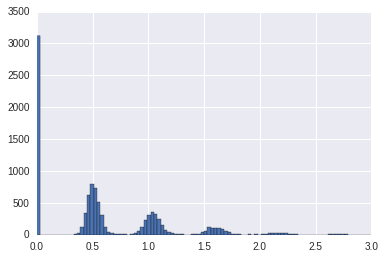

In [58]:
# Plot area histogram to survey area distinguishibility
# First bin will still be visible
# %matplotlib
plt.hist(areas,100,
         range=(0,3)
        );

In [59]:
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10124 but corresponding boolean dimension is 10000
  app.launch_new_instance()


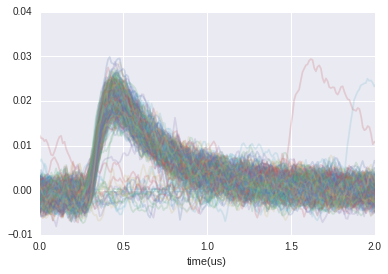

In [60]:
mask_1ph = (areas>0.2)&(areas<0.857)
# reload(hpa)
hpa.pplot(filelist[mask_1ph])
plt.xlim(0,2);

In [63]:
# Generate average pulse without horizontal offset correction
reload(pa)
time_p, signal_p = pa.trace_ave(filelist[:10000][mask_1ph], t_initial, t_final)

# Use average pulse to generate single photon model
def one_pulse(x, x_offset=0, amplitude=1):
    """convert the sample single photon pulse into a function
    that can be used in a fit
    """
    x = x - x_offset
    return amplitude * np.interp(x, time_p, signal_p)

fit_model = Model(one_pulse)

In [70]:
# Use model to generate another model that has horizontal offset correction
reload(pa)
time_f, signal_f, sigma_f = pa.fit_corrected_pulse(filelist[:10000][mask_1ph], 
                                                   fit_model,
                                                   t_initial,
                                                   t_final)
print('done!')

done!


[]

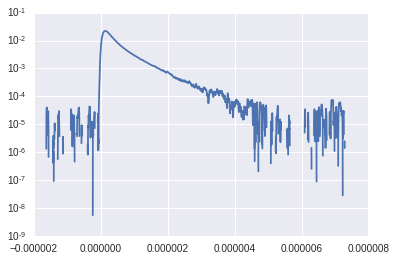

In [71]:
# plots single photon model in semilog axis to check vertical offset correction 
plt.plot(time_f,signal_f)
plt.semilogy()

<Container object of 3 artists>

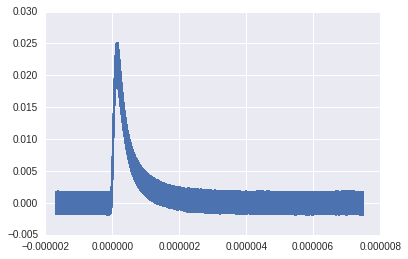

In [72]:
plt.errorbar(time_f, signal_f, yerr=sigma_f)

In [73]:
np.save(results_directory + 'ph1_model.npy',
            np.array(zip(time_f, signal_f, sigma_f)))

In [74]:
# fits the model back to the single photon pulse set to obtain jitter for single photon pulses
def fit_one(time,signal,height_th, time_model, signal_model):
    def one_pulse(x, x_offset=0, amplitude=1):
        """convert the sample single photon pulse into a function
        that can be used in a fit
        """
        x = x - x_offset
        return amplitude * np.interp(x, time_model, signal_model)
    p = Parameters()
    p.add('x_offset', time[hpa.find_idx(signal[:np.argmax(signal)],height_th)], vary=1)
    p.add('amplitude', 1, vary=1)
    result = Model(one_pulse).fit(signal, x=time, params=p)
    return result


In [75]:
results = []
for f in tqdm.tqdm(filelist[mask_1ph]):
    time, signal = hpa.trace_extr(f,h_th=height_th)
    try:
        result = fit_one(time, signal,
        height_th=height_th,
        time_model=time_f,
        signal_model=signal_f)
        results.append(result)
    except:
        pass # some traces were empty for some unknown reason...

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10124 but corresponding boolean dimension is 10000
  from ipykernel import kernelapp as app
100%|██████████| 3732/3732 [00:26<00:00, 142.98it/s]


In [76]:
# Extract Offsets
offsets=[r.best_values['x_offset'] for r in results]
np.savetxt(results_directory+'single_photon_arrival_times.dat',offsets)

297.6 320.0


22.399999999999977

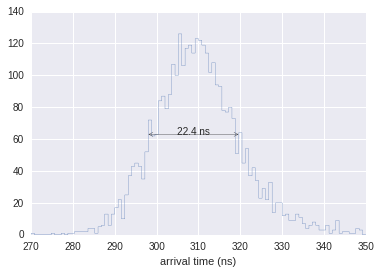

In [77]:
# Plot arrival time distribution
plt.hist(np.array(offsets)*1e9, 
         bins=100, 
         range = [270,350], 
#          alpha=0.5, 
#          label='without shift', 
         histtype='step', 
#          linestyle='-'
        )
plt.xlabel('arrival time (ns)')
# Compute Jitter for single photon pulse
t_hist = np.histogram(np.array(offsets)*1e9, bins=100, range=[270,350])
reload(noshift)
noshift.FWHM(t_hist[1]+np.diff(t_hist[1])[0]/2, t_hist[0]) 

# Fit to 2 photon traces
typically, we want to run over several folders, but as a start, we'll manually search and replace the folder names and variables corresponding to each folder.

In [78]:
# Imports double diode excitation traces
directory_name_90ns = '/workspace/projects/TES/data/20170405_TES5_SQ1_fit_accuracy_80mK_iBias_104uA_7.2GHZ_100kOhm/90ns/'
results_directory = './'
filelist_90ns = np.array(glob.glob(directory_name_90ns + '*.trc'))
print(filelist_90ns[:2])

[ '/workspace/projects/TES/data/20170405_TES5_SQ1_fit_accuracy_80mK_iBias_104uA_7.2GHZ_100kOhm/90ns/C2_double_90ns_avg_100_00000.trc'
 '/workspace/projects/TES/data/20170405_TES5_SQ1_fit_accuracy_80mK_iBias_104uA_7.2GHZ_100kOhm/90ns/C2_double_90ns_avg_100_00001.trc']


In [79]:
data_90ns = np.array([hpa.param_extr(f, t_initial=None, t_final=None, h_th=height_th)
                 for f
                 in tqdm.tqdm(filelist_90ns[:20000])])

100%|██████████| 20000/20000 [03:18<00:00, 100.71it/s]


In [80]:
# Generate Area histograms
areas_90ns = data_90ns['area_win']

# use the area to count the number of photons
pnr_90ns = np.histogram(areas_90ns, 200)

# remove the first bin that is not gaussian, and will affect the threshold detection algorithm

pnr_90ns = [pnr_90ns[0][1:], pnr_90ns[1][1:]]

Using matplotlib backend: TkAgg


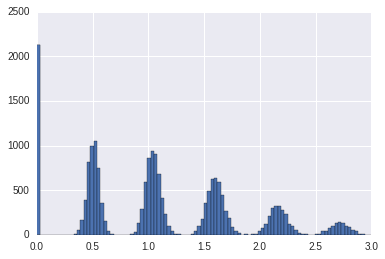

In [81]:
%matplotlib
plt.hist(areas_90ns,100,
         range=(0,3)
        );

In [82]:
%matplotlib inline

In [83]:
mask_2ph_90ns = (areas_90ns>0.9)&(areas_90ns<1.35)

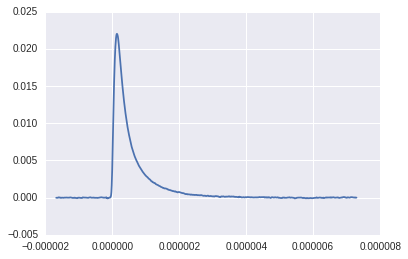

In [84]:
# Loads Single Photon Model
ph1_model = np.load(results_directory + 'ph1_model.npy')
time_f, signal_f = ph1_model[:,0], ph1_model[:,1]
time_f, signal_f = time_f[:-100], signal_f[:-100]
plt.plot(time_f,signal_f)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 27119 but corresponding boolean dimension is 20000
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


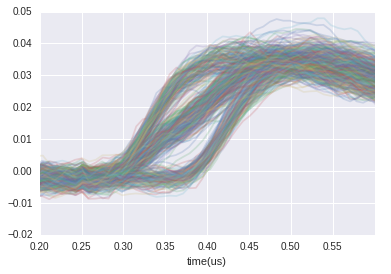

In [85]:
# Plots 2 Photons traces as a check
hpa.pplot(filelist_90ns[mask_2ph_90ns][:5000], plot_every=4)
# plt.plot(time_f*1e6,signal_f, label='single photon model')
plt.legend()
plt.xlim(0.2,0.6);
plt.savefig(results_directory+'persist_90ns.pdf')

## OPTIMISE AND TEST MCMC & LEAST SQUARES FITS

In [205]:
# MCMC
def fit_two_mcmc(time, signal, 
                 amplitude_init_min=0.7, amplitude_init_max=1.5, 
                 one_x_offset_init=None, 
                 Plot=False, debug=False, 
                 sampling=1e2):
    
    # LIMIT SEARCH FOR OFFSETS
    _t_initial=time[pd.srlatch_rev(signal,0)][0] 
#     _t_final=time[pd.srlatch_rev(signal,np.min(signal))][-1] 
    _t_final=time[pd.srlatch_rev(signal,0)][-1] 
    
    def model(x, f): 
        # PRIORS
        y_err = sigma0
        print (_t_initial,_t_final, one_x_offset_init)
        one_x_offset = pymc.Uniform("one_x_offset", _t_initial, _t_final, value=_t_initial)
        two_x_offset = pymc.Uniform("two_x_offset", _t_initial, _t_final, value=_t_final)
        one_x_amplitude = pymc.Normal("one_x_amplitude", mu=1, tau=1.0/((sigma/mu)**2), value=1) #sigma/mu is the n=1 std deviation in units of n=1 amplitude
        two_x_amplitude = pymc.Normal("two_x_amplitude", mu=1, tau=1.0/((sigma/mu)**2), value=1)
        # MODEL
        @pymc.deterministic(plot=False)
        def mod_two_pulse(x=time, 
                          one_x_offset=one_x_offset, 
                          two_x_offset=two_x_offset, 
                          one_x_amplitude=one_x_amplitude, 
                          two_x_amplitude=two_x_amplitude):
              return one_pulse(x, x_offset=one_x_offset, amplitude=one_x_amplitude)+\
            one_pulse(x, x_offset=two_x_offset, amplitude=two_x_amplitude)

        #likelihoodsy
        y = pymc.Normal("y", mu=mod_two_pulse, tau= 1.0/y_err**2, value=signal, observed=True)
        return locals()

    MDL = pymc.MCMC(model(time,signal), db='pickle') # The sample is stored in a Python serialization (pickle) database
    MDL.use_step_method(pymc.AdaptiveMetropolis, 
        [MDL.one_x_amplitude, MDL.two_x_amplitude],
        scales={MDL.one_x_amplitude:sigma/mu, 
                MDL.two_x_amplitude:sigma/mu}, 
        )
    MDL.sample(iter=sampling, burn=int(sampling*.95), thin=10)  
    # thin: consider every 'thin' samples
    # burn: number of samples to discard: decide by num of samples to run till parameters stabilise at desired precision
    if Plot:
        y_fit = MDL.mod_two_pulse.value #get mcmc fitted values
        plt.plot(time, signal, 'b', marker='o', ls='-', lw=1, label='Observed')
        plt.plot(time,y_fit,'k', marker='+', ls='--', ms=5, mew=2, label='Bayesian Fit Values')
        plt.legend()      
    if debug:
        pymc.Matplot.plot(MDL)
    return MDL #usage: MDL.one_x_offset.value for fitted result

In [213]:
# LEAST SQUARES - performs also MCMC within it
# Use average pulse to generate single photon model
def one_pulse(x, x_offset=0, amplitude=1):
    """convert the sample single photon pulse into a function
    that can be used in a fit
    """
    x = x - x_offset
    return amplitude * np.interp(x, time_f, signal_f)

two_pulse_fit = Model(one_pulse, prefix='one_') + \
        Model(one_pulse, prefix='two_')

def fit_two(time, signal, 
            height_th=height_th, 
            filterpts=301, 
            order=3, 
            thres=0.7, 
            min_dist=20, 
            sampling=2e4, 
            debug=False):
    
    # Identify Pulse Region
    [mask, clamp, edges, left_edges, right_edges] = pd.discriminator(time, signal, dt_left=300e-9,dt_right=800e-9, height_th=height_th, Plot=False, method=2)
    window = mask&clamp
    # Use MCMC
    result_mcmc = fit_two_mcmc(time[::1], signal[::1], sampling=sampling, debug=debug)
    # Use Least Squares
    p = Parameters()
    p.add('one_x_offset', result_mcmc.one_x_offset.value, vary=1)
    p.add('two_x_offset', result_mcmc.two_x_offset.value, vary=1)
    p.add('one_amplitude', result_mcmc.one_x_amplitude.value, min=0.5, max=1.5, vary=1) #warning: max >= 2 causes n=2 & noise to be fitted on a tau~0 2ph trace. 
    p.add('two_amplitude', result_mcmc.two_x_amplitude.value, min=0.5, max=1.5, vary=1)

    result = two_pulse_fit.fit(signal,
                               x=time,
                               params=p,
                               )
    return result, result_mcmc

In [203]:
# Test on a single trace
# mdl = fit_two_mcmc(*hpa.trace_extr(filelist_90ns[mask_2ph_90ns][0], t_initial, t_final), sampling=1.5e4)

In [198]:
def testmcmc(i, iters, height_th, Plot=True):
    result, result_mcmc = fit_two(*hpa.trace_extr(filelist_90ns[mask_2ph_90ns][i], 
                                                  t_initial=-2e-6, t_final=None), 
                                                  
                                  height_th=height_th, 
                                  sampling=iters)
    # pymc.gelman_rubin() #https://pymc-devs.github.io/pymc/modelchecking.html
    if Plot:
        plt.plot(*hpa.trace_extr(filelist_90ns[mask_2ph_90ns][i]), label='unwindowed')
        plt.plot(result_mcmc.time, result_mcmc.signal, 'b', marker='o', ls='-', lw=1, label='Observed')
        plt.plot(result_mcmc.time, result_mcmc.mod_two_pulse.value,'k', marker='+', ls='--', ms=5, mew=2, label='Bayesian Fit Values')
        plt.legend()
        print result.fit_report()
        print ('arrival time difference = {:.2f}ns'.\
               format((result.init_values['one_x_offset']-result.init_values['two_x_offset'])*1e9))
        pymc.Matplot.plot(result_mcmc)
    return result, result_mcmc

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 27119 but corresponding boolean dimension is 20000


(4.001985565776797e-07, 1.3001985311239414e-06, None)
 [-----------------100%-----------------] 50000 of 50000 complete in 15.9 sec

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 27119 but corresponding boolean dimension is 20000


[[Model]]
    (Model(one_pulse, prefix='one_') + Model(one_pulse, prefix='two_'))
[[Fit Statistics]]
    # function evals   = 14
    # data points      = 4910
    # variables        = 4
    chi-square         = 0.027
    reduced chi-square = 0.000
    Akaike info crit   = -59376.635
    Bayesian info crit = -59350.638
[[Variables]]
    one_x_offset:    4.0995e-07 +/- 0        (0.00%) (init= 4.099533e-07)
    two_x_offset:    9.6721e-07 +/- 0        (0.00%) (init= 9.67214e-07)
    one_amplitude:   1.50000000 +/- 0        (0.00%) (init= 1.5)
    two_amplitude:   0.81263067 +/- 0        (0.00%) (init= 0.5)
[[Correlations]] (unreported correlations are <  0.100)

arrival time difference = -557.26ns
Plotting one_x_amplitude
Plotting one_x_offset
Plotting two_x_offset
Plotting two_x_amplitude


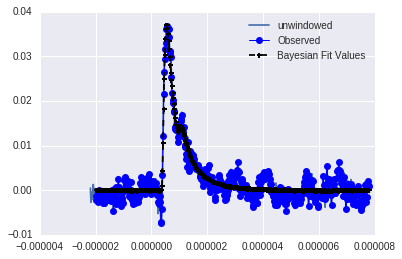

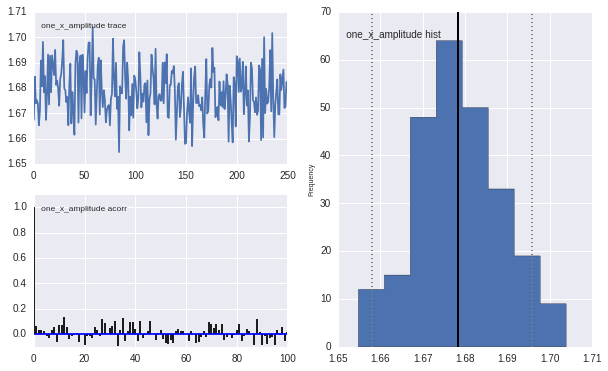

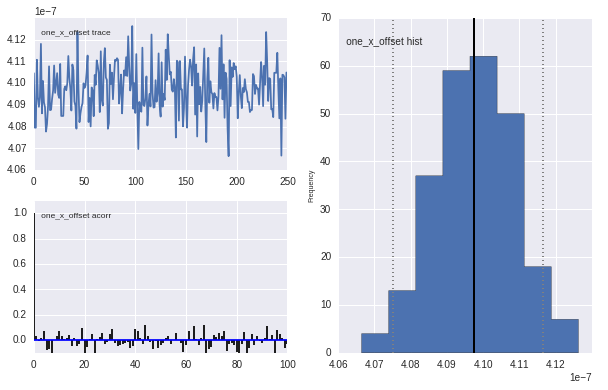

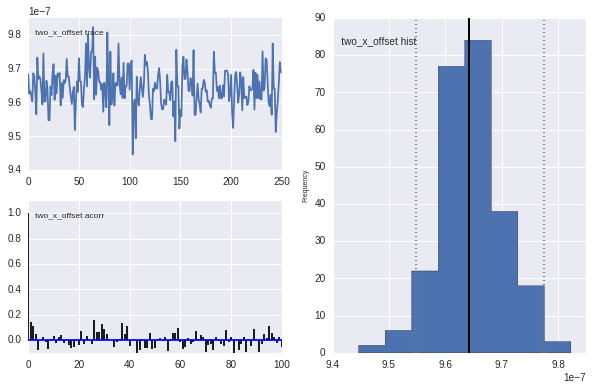

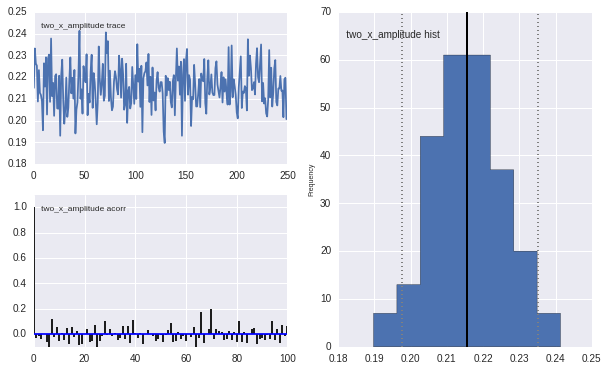

In [185]:
%matplotlib inline
a, b = testmcmc(2,5e4,height_th,Plot=True)

In [199]:
# results_90ns= np.array([fit_two(*hpa.trace_extr(file, t_initial=-2e-6, t_final=None), 
#                                 height_th=height_th,
#                                 sampling=2e4)#1.5e4 for 10us trace, 2ns per pt, sampled every 20 pts.
#                     for file
#                     in tqdm.tqdm(filelist_90ns[mask_2ph_90ns][::20])])

In [ ]:
from multiprocess import Pool

p = Pool(3)
def fit_two_poolable(file):
    time, signal = hpa.trace_extr(file, t_initial, t_final)
    result, result_mcmc = fit_two(time, signal, 
                                    height_th=height_th,
                                    sampling=2e4)
    return result

results_90ns = p.map(fit_two_poolable,
                    filelist_90ns[mask_2ph_90ns][::20])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 27119 but corresponding boolean dimension is 20000


(3.6838223979317075e-07, 1.3003822134344106e-06, None)
(3.848942971023926e-07, 1.0248942790019565e-06, None)
(2.8359523861530804e-07, 1.0815952160463267e-06, None)
 [-----------------100%-----------------] 20000 of 20000 complete in 23.6 sec(3.8301039824198863e-07, 1.2390103740326553e-06, None)
(3.1128679016998515e-07, 1.0792867684494618e-06, None)
(1.4747943018728279e-07, 1.0034794059779495e-06, None)
 [-----------------49%                  ] 9802 of 20000 complete in 12.5 secc

In [209]:
results_90ns

In [210]:
processed_90ns = pf.extract(results_90ns)

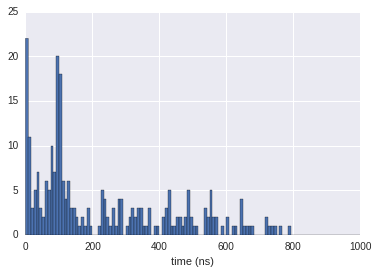

In [212]:
plt.hist(np.abs(processed_90ns._one_x_offsets_init
    -processed_90ns._two_x_offsets_init)*1e9,120, range=(0,1000));
plt.xlabel('time (ns)')
plt.savefig(results_directory+'arrival_times_90ns_new_2.pdf')

In [41]:
taus = np.abs(processed_90ns._one_x_offsets_init
    -processed_90ns._two_x_offsets_init)*1e9

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 27119 but corresponding boolean dimension is 20000
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 5219 but corresponding boolean dimension is 261
  if __name__ == '__main__':


(0, 1)

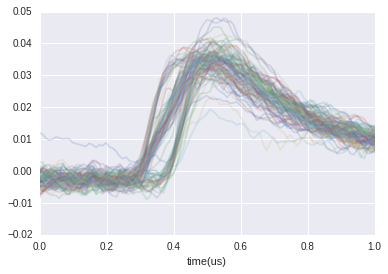

In [42]:
hpa.pplot(filelist_90ns[mask_2ph_90ns][taus>100],density=1)
plt.xlim(0,1)

In [43]:
(mu_t,sigma_t)=norm.fit(taus[taus>30])

In [44]:
(mu_t,sigma_t)

(106.36291507240364, 41.227739730002291)